<a href="https://colab.research.google.com/github/SwetaSengupta/DS-Unit-2-Linear-Models/blob/master/Sweta_Sengupta__LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [27]:
print(df.shape)
df.head()

(421, 61)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great,year,month
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2016,1
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2016,1
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2016,1
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2016,1
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2016,1


In [31]:
df.year.value_counts()

2016    296
2017     85
2018     27
2019     10
2026      1
2015      1
2011      1
Name: year, dtype: int64

###Train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [0]:
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month

In [37]:
condition = df['year']<=2016
train = df[condition]
train.shape

(298, 61)

In [38]:
condition_1 = df['year']==2017
val=df[condition_1]
val.shape

(85, 61)

In [39]:
condition_2 = df['year']>=2018
test = df[condition_2]
test.shape

(38, 61)

###Baselines for classification

In [40]:
#Determine majority class
target='Great'
y_train = train[target]
y_train.value_counts(normalize= True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [0]:
# guessing the majority class for evry prediction
majority_class = y_train.mode()[0]
y_pred_train = [majority_class]*len(y_train)

In [0]:
# baseline accuracy if we guessed the majority class for every prediction

In [42]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_pred_train)

0.5906040268456376

In [43]:
y_val = val[target]
y_pred = [majority_class]*len(y_val)
accuracy_score(y_val, y_pred)

0.5529411764705883

###Linear regression

In [44]:
train .describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso,year,month
count,71.000000,71.000000,292.000000,297.000000,0.0,0.0,175.000000,174.000000,174.000000,298.000000,283.000000,288.000000,297.000000,292.000000,296.000000,278.000000,296.000000,296.000000,0.0,298.000000,298.000000
mean,3.897183,4.142254,6.896781,3.445286,NaN,NaN,19.829886,22.042241,0.770920,3.472315,3.706360,3.551215,3.519024,3.528870,3.395946,3.324640,3.540203,3.955068,NaN,2015.979866,6.436242
std,0.478680,0.371738,1.211412,0.852150,NaN,NaN,2.081275,1.685043,0.137833,0.797606,0.991897,0.869483,0.850348,1.040457,1.089044,0.971226,0.922426,1.167341,NaN,0.295187,2.892745
min,2.500000,2.900000,2.990000,0.500000,NaN,NaN,15.000000,17.000000,0.400000,1.400000,1.000000,1.000000,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000,NaN,2011.000000,1.000000
25%,3.500000,4.000000,6.250000,3.000000,NaN,NaN,18.500000,21.000000,0.662500,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.500000,3.000000,3.500000,NaN,2016.000000,4.000000
50%,4.000000,4.200000,6.850000,3.500000,NaN,NaN,19.500000,22.000000,0.750000,3.500000,4.000000,3.500000,3.500000,4.000000,3.500000,3.500000,3.750000,4.000000,NaN,2016.000000,6.000000
75%,4.000000,4.400000,7.500000,4.000000,NaN,NaN,21.000000,23.000000,0.870000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN,2016.000000,9.000000
max,4.500000,4.900000,11.950000,5.000000,NaN,NaN,26.000000,27.000000,1.240000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN,2016.000000,12.000000


In [45]:
# 1. Import estimator class
from sklearn.linear_model import LinearRegression
# 2. Instantiate this class
linear_reg = LinearRegression()

# 3. Arrange X feature matrices (already did y target vectors)
features = ['Yelp', 'Cost', 'Hunger']
X_train = train[features]
X_val = val[features]

# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# 4. Fit the model
linear_reg.fit(X_train_imputed, y_train)

# 5. Apply the model to new data.
# The predictions look like this ...
linear_reg.predict(X_val_imputed)

array([0.39236891, 0.39236891, 0.54182826, 0.5163008 , 0.30486651,
       0.36498635, 0.4267666 , 0.46608992, 0.58173853, 0.47182056,
       0.33837985, 0.45119951, 0.41961156, 0.41157941, 0.45605964,
       0.48543172, 0.53864263, 0.38286008, 0.42734032, 0.42734032,
       0.42734032, 0.45886176, 0.38289314, 0.49335179, 0.4804595 ,
       0.43597926, 0.33557734, 0.45032239, 0.43597926, 0.45032239,
       0.48899887, 0.49190094, 0.40671927, 0.40671927, 0.54782263,
       0.6545752 , 0.29495029, 0.33267565, 0.61525149, 0.3742542 ,
       0.62761824, 0.57883685, 0.45605964, 0.45605964, 0.4253422 ,
       0.4431343 , 0.65170657, 0.43878138, 0.4904501 , 0.42018528,
       0.4640918 , 0.43108606, 0.51572707, 0.51572707, 0.48561641,
       0.46463246, 0.37712283, 0.1767714 , 0.38204908, 0.33756885,
       0.43425808, 0.54929482, 0.37513132, 0.4640918 , 0.53293222,
       0.55072431, 0.45032239, 0.5163008 , 0.58659867, 0.25646441,
       1.49737101, 0.46466552, 0.48268789, 0.3814423 , 0.43425

In [46]:
features

['Yelp', 'Cost', 'Hunger']

In [47]:
# Get coefficients
pd.Series(linear_reg.coef_, features)

Yelp      0.180866
Cost      0.057373
Hunger    0.088960
dtype: float64

In [48]:
test_case = [[3.5, 7.00, 3]] 
linear_reg.predict(test_case)

array([0.30386808])

###Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))


Validation Accuracy 0.5294117647058824


In [50]:
# The predictions look like this
log_reg.predict(X_val_imputed)

array([False, False,  True,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False,  True, False,  True,  True, False, False, False,
       False,  True, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False,  True, False,
       False,  True,  True, False,  True,  True, False,  True, False,
       False, False, False,  True, False, False,  True,  True, False,
       False,  True,  True,  True])

In [51]:
log_reg.predict(test_case)

array([False])

In [52]:
log_reg.predict_proba(test_case)[0]

array([0.68820486, 0.31179514])

In [53]:
# What's the math?
log_reg.coef_

array([[0.63709728, 0.25154941, 0.39556501]])

In [54]:
log_reg.intercept_

array([-5.96912155])

###Validation accuracy.

In [55]:
train.head(2)

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great,year,month
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2016,1
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2016,1


In [0]:
features = ['Burrito', 'Yelp','Google','Chips','Cost', 'Hunger','Tortilla','Temp', 'Meat', 'Fillings','Meat:filling','Uniformity','Salsa','Synergy','Wrap']
target ="Great"

In [57]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_train.shape, X_val.shape

((298, 15), (85, 15))

In [0]:
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

In [59]:
# stretch goal-one hot encoding Burrito column
encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_val_enc = encoder.transform(X_val)
X_train_enc.shape, X_val_enc.shape

((298, 21), (85, 21))

In [60]:
X_val_enc.head()

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Yelp,Google,Chips_nan,Chips_x,Chips_X,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
301,1,0,0,0,0,NaN,NaN,1,0,0,6.60,NaN,4.0,4.5,4.0,3.5,3.5,5.0,1.5,3.50,4.5
302,0,0,0,1,0,NaN,NaN,1,0,0,6.60,NaN,4.0,2.0,NaN,4.0,NaN,4.6,4.2,3.75,5.0
303,0,0,0,1,0,NaN,NaN,1,0,0,8.50,3.9,3.0,4.5,4.1,3.0,3.7,4.0,4.3,4.20,5.0
304,0,0,0,1,0,NaN,NaN,1,0,0,7.90,4.0,3.5,4.0,4.0,3.0,4.0,4.5,4.0,3.80,4.8
305,0,0,0,1,0,NaN,NaN,1,0,0,4.99,3.5,2.5,4.5,3.0,2.5,3.0,3.0,2.0,2.00,4.0


In [61]:
#filling the missing values
imputer = SimpleImputer(strategy='mean')
X_train_imp = imputer.fit_transform(X_train_enc)
X_val_imp = imputer.transform(X_val_enc)
X_train_imp.shape, X_val_imp.shape

((298, 21), (85, 21))

In [0]:
#Simple Imputer returns ndarray tharefore conveting back to df

X_train_imp = pd.DataFrame(X_train_imp, columns=X_train_enc.columns)
X_val_imp = pd.DataFrame(X_val_imp, columns = X_val_enc.columns)

In [63]:
X_val_imp

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Yelp,Google,Chips_nan,Chips_x,Chips_X,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,1.0,0.0,0.0,0.0,0.0,3.897183,4.142254,1.0,0.0,0.0,6.60,3.445286,4.0,4.5,4.000000,3.5,3.50000,5.0,1.5,3.50,4.5
1,0.0,0.0,0.0,1.0,0.0,3.897183,4.142254,1.0,0.0,0.0,6.60,3.445286,4.0,2.0,3.551215,4.0,3.52887,4.6,4.2,3.75,5.0
2,0.0,0.0,0.0,1.0,0.0,3.897183,4.142254,1.0,0.0,0.0,8.50,3.900000,3.0,4.5,4.100000,3.0,3.70000,4.0,4.3,4.20,5.0
3,0.0,0.0,0.0,1.0,0.0,3.897183,4.142254,1.0,0.0,0.0,7.90,4.000000,3.5,4.0,4.000000,3.0,4.00000,4.5,4.0,3.80,4.8
4,0.0,0.0,0.0,1.0,0.0,3.897183,4.142254,1.0,0.0,0.0,4.99,3.500000,2.5,4.5,3.000000,2.5,3.00000,3.0,2.0,2.00,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,1.0,0.0,0.0,0.0,0.0,3.897183,4.142254,1.0,0.0,0.0,6.85,3.500000,3.0,4.5,3.800000,3.8,4.00000,3.5,3.5,4.00,3.0
81,1.0,0.0,0.0,0.0,0.0,3.897183,4.142254,1.0,0.0,0.0,6.85,3.500000,3.0,4.5,4.000000,4.0,4.50000,3.0,4.0,4.00,3.5
82,0.0,0.0,0.0,1.0,0.0,4.000000,4.500000,0.0,0.0,0.0,11.50,3.500000,2.0,2.0,4.000000,3.5,3.00000,4.5,3.5,4.00,2.0
83,1.0,0.0,0.0,0.0,0.0,3.897183,4.142254,1.0,0.0,0.0,7.89,4.000000,4.0,3.0,4.000000,4.0,3.00000,4.0,3.5,4.30,4.5


In [0]:
#  Stretch goals - Feature scaling using standard scaler

In [0]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_imp)
X_val_sc = scaler.transform(X_val_imp)

In [0]:
# Standard scaler retuns ndarray therefore converting to df

X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_enc.columns)
X_val_sc = pd.DataFrame(X_val_sc, columns = X_val_enc.columns)

In [66]:
X_train_sc.head()

,Burrito_California,Burrito_Carnitas,Burrito_Asada,Burrito_Other,Burrito_Surf & Turf,Yelp,Google,Chips_nan,Chips_x,Chips_X,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,1.235080,-0.222027,-0.364801,-0.764922,-0.27534,-1.712002e+00,3.205145e-01,0.282330,-0.260960,-0.100844,-0.339805,-0.524307,-0.593162,1.340696,-0.645992,-0.022447,0.458224,0.557478,0.721245,0.500993,0.038686
1,1.235080,-0.222027,-0.364801,-0.764922,-0.27534,-1.712002e+00,-4.674821e+00,0.282330,-0.260960,-0.100844,-1.208571,0.064423,-1.849023,-0.213867,-1.231964,-1.202403,-1.486989,0.557478,0.187274,-1.133401,0.899679
2,-0.809664,4.503967,-0.364801,-0.764922,-0.27534,1.914185e-15,-4.929721e-15,0.282330,-0.260960,-0.100844,-1.709783,-2.290496,-0.593162,-1.768429,-1.231964,-0.612425,0.944528,0.557478,-0.346697,-0.588603,0.899679
3,-0.809664,-0.222027,2.741220,-0.764922,-0.27534,1.914185e-15,-4.929721e-15,0.282330,-0.260960,-0.100844,-1.375642,-1.701766,-0.593162,-1.768429,-0.060021,-0.612425,0.458224,1.480371,0.721245,0.500993,0.899679
4,1.235080,-0.222027,-0.364801,-0.764922,-0.27534,4.431779e-01,-1.899635e+00,-3.541956,3.831998,-0.100844,-0.256270,0.653153,0.662698,1.340696,0.525950,-0.022447,0.944528,1.480371,-0.880668,1.045791,0.038686


##Logistic regression CV


In [99]:
model = LogisticRegressionCV()
model.fit(X_train_sc, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [100]:
print(f'Validation score: {model.score(X_val_sc, y_val)}')

Validation score: 0.8705882352941177


In [102]:
# testing with Cs=9
model = LogisticRegressionCV(Cs=9)
model.fit(X_train_sc, y_train)
print(f'Validation score: {model.score(X_val_sc, y_val)}')

Validation score: 0.8823529411764706


#Stretch Goals

##1)Plot coefficients:

In [69]:
coefs = pd.Series(model.coef_[0], X_train_sc.columns)
coefs

Burrito_California     0.137943
Burrito_Carnitas       0.022991
Burrito_Asada         -0.006121
Burrito_Other         -0.084952
Burrito_Surf & Turf   -0.114720
Yelp                   0.096825
Google                -0.003336
Chips_nan              0.005029
Chips_x               -0.007554
Chips_X                0.005316
Cost                   0.220811
Hunger                 0.104332
Tortilla               0.320757
Temp                   0.271194
Meat                   0.582954
Fillings               0.567975
Meat:filling           0.499896
Uniformity             0.184430
Salsa                  0.251758
Synergy                0.667542
Wrap                   0.072903
dtype: float64

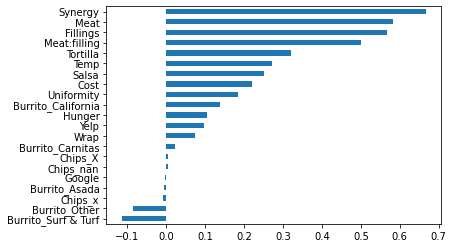

In [70]:
coefs.sort_values().plot.barh()

###Test Accuracy

In [77]:
X_test = test[features]
X_test_enc = encoder.transform(X_test)
X_test_imp = imputer.transform(X_test_enc)
X_test_scaled = scaler.transform(X_test_imp)
X_test_scaled

array([[ 1.23508045e+00, -2.22026518e-01, -3.64801107e-01,
        -7.64922469e-01, -2.75340288e-01,  1.91418451e-15,
        -4.92972144e-15,  2.82329851e-01, -2.60960454e-01,
        -1.00843897e-01,  9.21576515e-01,  6.53153184e-01,
         1.29062863e+00,  1.34069563e+00,  1.69789203e+00,
         1.74748664e+00,  9.44527829e-01,  1.48037108e+00,
        -3.46697110e-01,  1.59058956e+00,  8.99678662e-01],
       [ 1.23508045e+00, -2.22026518e-01, -3.64801107e-01,
        -7.64922469e-01, -2.75340288e-01,  1.91418451e-15,
        -4.92972144e-15,  2.82329851e-01, -2.60960454e-01,
        -1.00843897e-01,  2.95062401e-01,  6.53153184e-01,
         6.62698293e-01,  1.34069563e+00,  5.25949777e-01,
         1.74748664e+00,  1.43083126e+00, -3.65415944e-01,
        -3.46697110e-01,  5.00993379e-01,  8.99678662e-01],
       [-8.09663853e-01, -2.22026518e-01, -3.64801107e-01,
         1.30732204e+00, -2.75340288e-01,  2.59835806e+00,
        -1.89963467e+00,  2.82329851e-01, -2.60960454e

In [0]:
target = 'Great'
y_test = test[target]

In [110]:
model = LogisticRegressionCV()
model.fit(X_test_scaled, y_test)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [112]:
print(f'Test accuracy score: {model.score(X_test_scaled, y_test)}')

Test accuracy score: 0.8947368421052632


##Kaggle Submission

In [78]:
y_pred = model.predict(X_test_scaled)
y_pred

array([ True,  True, False,  True, False, False,  True,  True, False,
        True,  True, False,  True, False,  True,  True,  True, False,
       False, False, False,  True, False,  True,  True, False, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True])

In [81]:
submission = test[['Cost']].copy()
submission

,Cost
77,8.00
386,7.25
387,4.19
388,7.00
389,8.50
390,7.20
391,5.99
392,5.99
393,5.99
394,8.99


In [82]:
submission['Great'] = y_pred
submission

,Cost,Great
77,8.00,True
386,7.25,True
387,4.19,False
388,7.00,True
389,8.50,False
390,7.20,False
391,5.99,True
392,5.99,True
393,5.99,False
394,8.99,True
